# Все необходимые импорты

In [8]:
import pandas as pd # библиотека для работы с табличными данными
import matplotlib.pyplot as plt # библиотека для постороения графиков
import seaborn as sns # библиотека для построения графиков
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error)  # библиотека для машинного обучения, ее подраздел с метриками
from pylab import rcParams # библиотека для работы с графиками
from sklearn.model_selection import ParameterGrid # библиотека для машинного обучения, ее подраздел с классами для подбора гиперпараметров модели
from statsmodels.tsa.arima.model import ARIMA # библиотека для работы со статистическими моделями
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # библиотека для работы со статистикой и ее подраздел с графкиами автокорреляции и 
from statsmodels.tsa.stattools import adfuller # библиотека для работы со статистикой и ее подраздел со статистическими тестами
import warnings # библиотека для контроля "варнингов"

warnings.simplefilter(action = 'ignore', category = Warning) # статистические модели дают много предупреждений, делаем так чтобы они не отображались

sns.set() # приводим вид всех графиков к общему стандарту (просто чтобы было приятно глазу)

# DATA FROM

## EDA
На этом этапе ознакомимся с данными: узнаем размер датафрейма, проверим наличие полных дубликатов и пропусков.

In [9]:
# Дирректория локальная, для вашего компьютера будет необходимо будет изменить путь к датасету
data_from = pd.read_excel('/Users/matveyvolshchukov/Desktop/Done_Arima/2024_ИндЗаданиеARIMA/!Исходные данные за 4 дня/Данные для Арима ЛПЦ11/Шагающая_Балка/LPC_Step_B_Data_From.xlsx') # считываем таблицу в датафрейм
data_from['Дата'] = pd.to_datetime(data_from['Дата'], format='%y-%m-%d %H:%M:%S.%f') # приводим дату к нужному формату
data_from.sample(5) # выводим 5 рандомных значений, чтобы убедиться что все считалось верно

,Дата,Откуда
1145,2024-03-28 15:22:37.641,НТА.М1.ШБ1.2 [x=634442 y=5922278.04 z=5.95]
9170,2024-03-26 06:23:10.797,НТА.ШБ1.13 [x=634423.6 y=5922285.44 z=6.054]
9192,2024-03-26 06:16:55.637,НТА.ШБ1.14 [x=634420.6 y=5922285.44 z=6.057]
4807,2024-03-27 15:46:14.745,НТА.ШБ1.13 [x=634423.6 y=5922285.44 z=6.225]
5829,2024-03-27 08:09:10.626,НТА.ШБ1.14 [x=634420.6 y=5922285.44 z=6.215]


Узнаем размер датафрейма

In [10]:
print("Размер датафрейма:", data_from.shape[0]) # получаем и выводим рзамер датафрейма

Размер датафрейма: 13167


Узнаем число полных дубликатов, т.е. строк данных идентичных друг другу
P.S. Их необходимо удалять, так как они ухудшают работу модели

In [11]:
print("Число полных дубликатов:", data_from.duplicated().sum()) # получаем и выводим количество дубликатов

Число полных дубликатов: 0


Узнаем количество пропусков в строках данных, чтобы очистить датафрейм от них - пропуски так же ухудшают рабоу модели (статистические модли, такие как ARIMA вряд-ли умеют их обрабатывать), заполнить нам их нечем, следовательно будем их удалять

In [12]:
print("Количество пропусков в каждом столбце датафрейма: ") # выводим текст
data_from.isna().sum() # получаем и выводим количество пропусков в каждом столбце датафрейма

Количество пропусков в каждом столбце датафрейма: 


Дата        0
Откуда    969
dtype: int64

Удаляем пропуски и проверяем, что их не осталось и мы все сделали верно

In [13]:
data_from.dropna(inplace=True) # удаляем все пропуски
data_from.isna().sum() # выодим количество пропусков по каждому столбцу

Дата      0
Откуда    0
dtype: int64

Проверим, что типы данных заданиы правильно

In [14]:
data_from.dtypes # выводим типы данных в датафрейме

Дата      datetime64[ns]
Откуда            object
dtype: object

Удаляем координаты из столбца откуда

In [15]:
data_from['Откуда'] = data_from['Откуда'].str.replace(r'\[.*\]', '', regex=True).str.strip() # удаляем все координаты из второго столбца
data_from.head() # выводим датафрейм

,Дата,Откуда
0,2024-03-28 22:36:46.629,НТА.ШБ1.14
1,2024-03-28 22:36:07.605,НТА.М.ШБ1.8
2,2024-03-28 22:35:37.627,НТА.ШБ2.16
3,2024-03-28 22:35:30.612,НТА.М2.ШБ1.6
4,2024-03-28 22:34:56.603,НТА.М2.ШБ1.5


## Ресемплирование и вывод графиков
Так как нам дано мало данных, а модели необходимо на чем-то обучаться ресемплируем датафрейм по одному часу. После чего приведем дату к формату datetime и сделаем ее индексам (так принято при работе со временными рядами). На всякий случаем отсортируем индексы, чтобы дата и время шли по порядку.

После по всем данным построим график со скользящим средним и стандартным отклонением. Проведем тест на стационарность.

In [16]:
data_from.set_index('Дата', inplace=True) # делаем дату индексом нашего датафрейма (теперь это объект сериес, но для удобства я продолжу называть его датафреймом - разницы особой нет)
data_from = data_from.sort_index() # сортируем индексы, чтобы даты шли по порядку

resampled_data_from = data_from['Откуда'].resample('1H').apply(lambda x: len(x)) # ресемлируем данные по одному часу и считаем количество вызовов кранов за час
resampled_data_from.head() # выводим первые пять элементов, чтобы знать как выглядит датафрейм сейчас

Дата
2024-03-24 22:00:00     50
2024-03-24 23:00:00    124
2024-03-25 00:00:00    107
2024-03-25 01:00:00    136
2024-03-25 02:00:00    149
Freq: H, Name: Откуда, dtype: int64

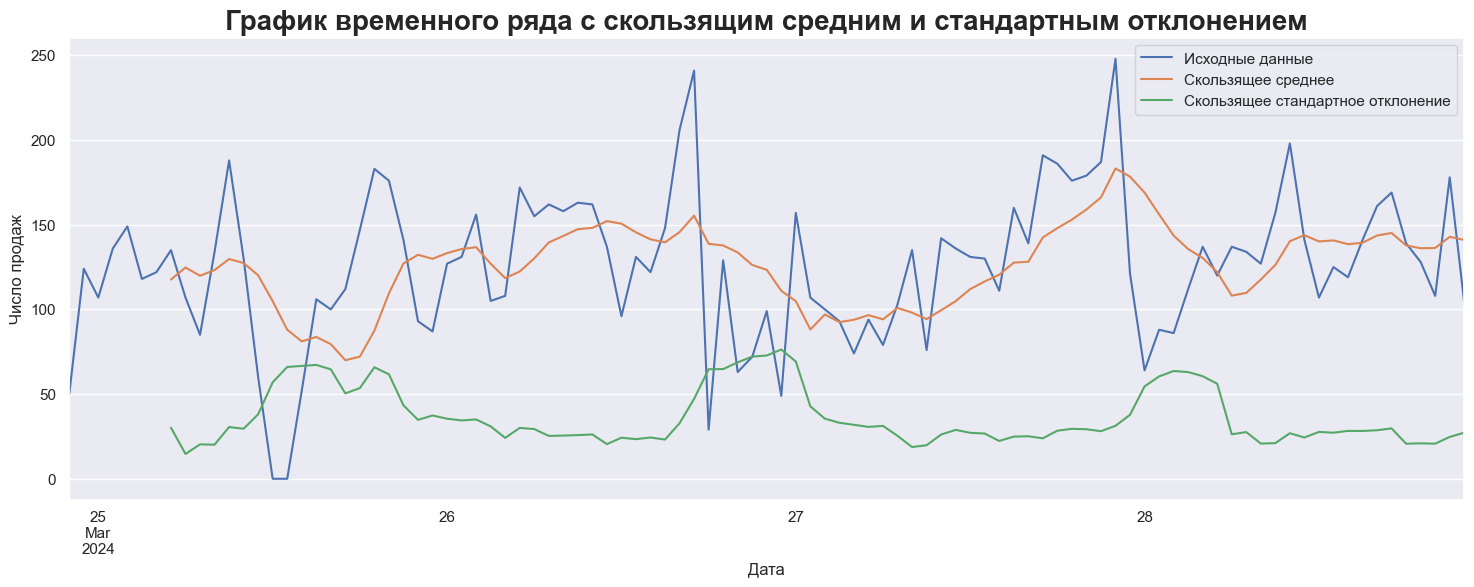

In [17]:
rolling_mean = resampled_data_from.rolling(window=8).mean() # создаем скользящее среднее с окном 8
rolling_std = resampled_data_from.rolling(window=8).std() # создаем скользящее стандартрное отклонение с окном 8

fig, ax = plt.subplots(figsize=(18, 6)) # задаем размер графика 
ax.set_title('График временного ряда с скользящим средним и стандартным отклонением', fontdict={'fontsize': 20, 'fontweight': 'bold'}) # подписываем график и задаем шрифт
ax.set_xlabel('Месяца', fontsize=12) # подписываем ось X
ax.set_ylabel('Число продаж', fontsize=12) # подписываем ось Y

resampled_data_from.plot(ax=ax, label='Исходные данные') # строим график по исходным данным

rolling_mean.plot(ax=ax, label='Скользящее среднее') # строим график скользящего стреднего

rolling_std.plot(ax=ax, label='Скользящее стандартное отклонение') # строим график скользящего стандартного отклонения

plt.legend() # добавляем легенду на график
plt.show() # выдоим графки на экран

Проведем тест, на стационарность данных, для этого выдвенем две гипотезу:
- **H0** - верменной ряд не является стационарным
- **H1** - временной ряд стационарен
   
Для проверки гипотезы будем использовать тест Дики-Фуллера

In [18]:
alpha = 0.05 # задаем пороговове значение (оно стандартное)
adf_test = adfuller(resampled_data_from.values) # проводим тест на наших данных

print('p-value = ', str(adf_test[1])) # выводи p-занчение проверям, выше или ниже оно нашего порогового значения

if adf_test[1] > alpha: # если p-value больше альфа принимаем гипотезу, иначе отвергаем
    print('Принимаем нулевую гипотезу') # выводим текст о принятии
else:
    print('Отвергаем нулевую гипотезу') # выводим текст о отвержении гипотезы

p-value =  1.437403285749635e-07
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу, из чего можем предположить, что ряд является стационарным и не требует дифференцирования

Выводим график ACF по которому определяем параметр `p`

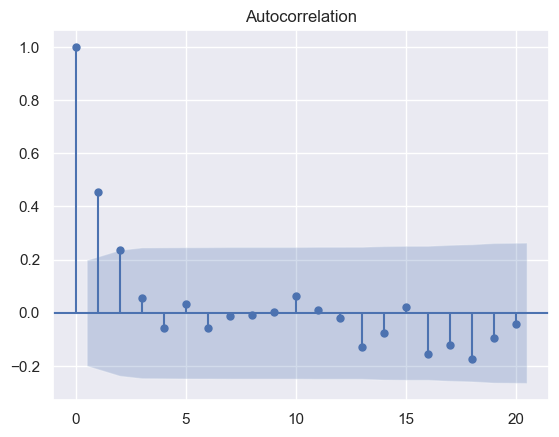

In [19]:
plot_acf(resampled_data_from) # создаем график ACF
plt.axis('tight') # задаем параметры необходимые для вывода
plt.show() # выводим график

Опитимальный параметр `p` находится в промежутке от 0 до 3

Строим график PACF, по которму определяем параметр `q`

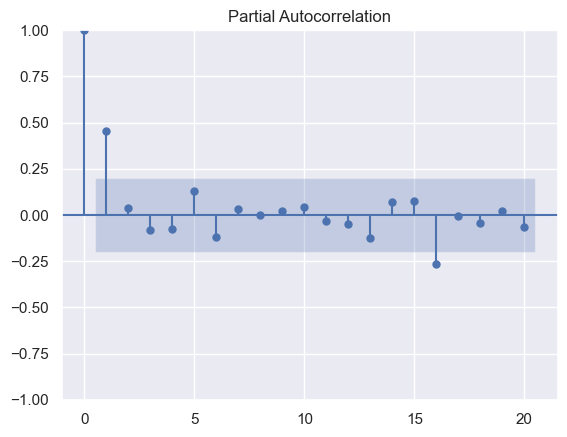

In [20]:
plot_pacf(resampled_data_from, method='ywm') # создаем график PACF с необходимыми параметрами
plt.show() # выводим график на экран

Оптимальный паметр `q` назодится в промежутке от 0 до 16

## Обучение модели для DATA_FROM

Протестируем модель на четырех метриках, потом по графикам выберем модель которая предсказывает данные лучше всего.

In [21]:
alpha = int(len(resampled_data_from) * 0.9) # задаеим процент данных который войдет в тестовую и тренировочную выборку
train_from = resampled_data_from[:alpha] # задаем тренировочную выборку (90% данных)
test_from = resampled_data_from[alpha:] # задаем тестовую выборку (10% от данных)

Проверим, что разделили првильно и значения в тестовой и тренировочной выборке идут по порядку. Для этого посмотрим на последний элемент тренировочной выборки и первый элемент тестовой

In [22]:
train_from.tail() # выводим последние 5 значений тестовой выборки

Дата
2024-03-28 08:00:00    127
2024-03-28 09:00:00    157
2024-03-28 10:00:00    198
2024-03-28 11:00:00    141
2024-03-28 12:00:00    107
Freq: H, Name: Откуда, dtype: int64

In [23]:
test_from.head() # выводим первые 5 значений тренировочной выборки 

Дата
2024-03-28 13:00:00    125
2024-03-28 14:00:00    119
2024-03-28 15:00:00    141
2024-03-28 16:00:00    161
2024-03-28 17:00:00    169
Freq: H, Name: Откуда, dtype: int64

## Подбор параметров по метрикам

Задаем перебор параметров модели, создаем массивы в, которых будут храниться значения метрик после подстановки различных гиперпараметров.

In [24]:
parameters = {'p': range(0, 4), 'd': range(0, 2), 'q': range(0, 16)} # задаем перебор параметров

# создаем массивы в которых будем хранить метрики
met_mse = [] # массив для метрик MSE
met_mae = [] # массив для метрик MAE
met_r2 = [] # массив для метрик R2
met_mape = [] # массив для метрик MAPE

for params in ParameterGrid(parameters): # задаем перебор параметров
    try: # если параметры можно подставить
        model = ARIMA(train_from, order=(params['p'], params['d'], params['q'])) # подставляем параметры в модель
        model_fit = model.fit() # обучаем модель

        predictions = model_fit.forecast(steps=len(test_from)) # деалаем предсказание
        
        # получаем результат MSE и добавляем его в массив
        metric_mse = mean_squared_error(test_from, predictions)  # получаем значение метрики MSE
        met_mse.append((params, metric_mse)) # кладем значение метрики и параметры модели в массив

        # получаем резльтат MAE и добавляем его в массив
        metric_mae = mean_absolute_error(test_from, predictions) # получаем значение метрики MAE
        met_mae.append((params, metric_mae)) # кладем значение метрики и параметры модели в массив 
    
        # получаем резльтат R2 и добавляем его в массив
        metric_r2 = r2_score(test_from, predictions) # получаем значение метрики R2
        met_r2.append((params, metric_r2)) # кладем значение метрики и параметры модели в массив 

        
        # получаем резльтат MAPE и добавляем его в массив
        metric_mape = mean_absolute_percentage_error(test_from, predictions) # получаем значение метрики MAPE
        met_mape.append((params, metric_mape)) # кладем значение метрики и параметры модели в массив 
    except: # если подставить значение в модель не удалось и код выдал ошибку, пропускаеи и идем дальше 
        continue # оператор для перехода на следующую итерацию

Выводим лучшие параметры модели и метрики которы они выдали

In [25]:
# выводим лучшие метрики и их параметры
print(f'MSE: {min(met_mse, key=lambda x: x[1])}') # выводим лучшую метрику MSE
print(f'MAE: {min(met_mae, key=lambda x: x[1])}') # выводим лучшую метрику MAE
print(f'R2: {max(met_r2, key=lambda x: x[1])}') # выводим лучшую метрику R2
print(f'MAPE: {min(met_mape, key=lambda x: x[1])}') # выводим лучшую метрику MAPE

MSE: ({'d': 1, 'p': 1, 'q': 3}, 592.9189475569164)
MAE: ({'d': 1, 'p': 1, 'q': 3}, 19.661316370595152)
R2: ({'d': 1, 'p': 1, 'q': 3}, -0.02588232326963169)
MAPE: ({'d': 1, 'p': 1, 'q': 3}, 0.13975770902803436)


По метрикам MSE и R2 получились одинаковые параметры p, d, q.

### Модель с лучшим MSE и R2

In [26]:
model_from_best_mse_r2 = ARIMA(train_from, order=(3, 1, 2)) # задаем модель с лучшими параметрами для метрик MAE и R2
model_from_best_mse_r2 = model_from_best_mse_r2.fit() # обучаем модель

In [27]:
start = len(train_from) # задаем старт для предсказания модели
end = len(train_from) + len(test_from) - 1 # задаем конец для предсказания

# делаем предсказания и выводим их на экран
predictions_from_mse_r2 = model_from_best_mse_r2.predict(start, end) # получаем предсказания
predictions_from_mse_r2.index = test_from.index # зпаисываем предсказания в датафрейм для хранения
predictions_from_mse_r2.head() # выводим первые пять строк предсказаний

Дата
2024-03-28 13:00:00    120.930618
2024-03-28 14:00:00    118.740992
2024-03-28 15:00:00    122.799789
2024-03-28 16:00:00    121.396436
2024-03-28 17:00:00    123.492895
Freq: H, Name: predicted_mean, dtype: float64

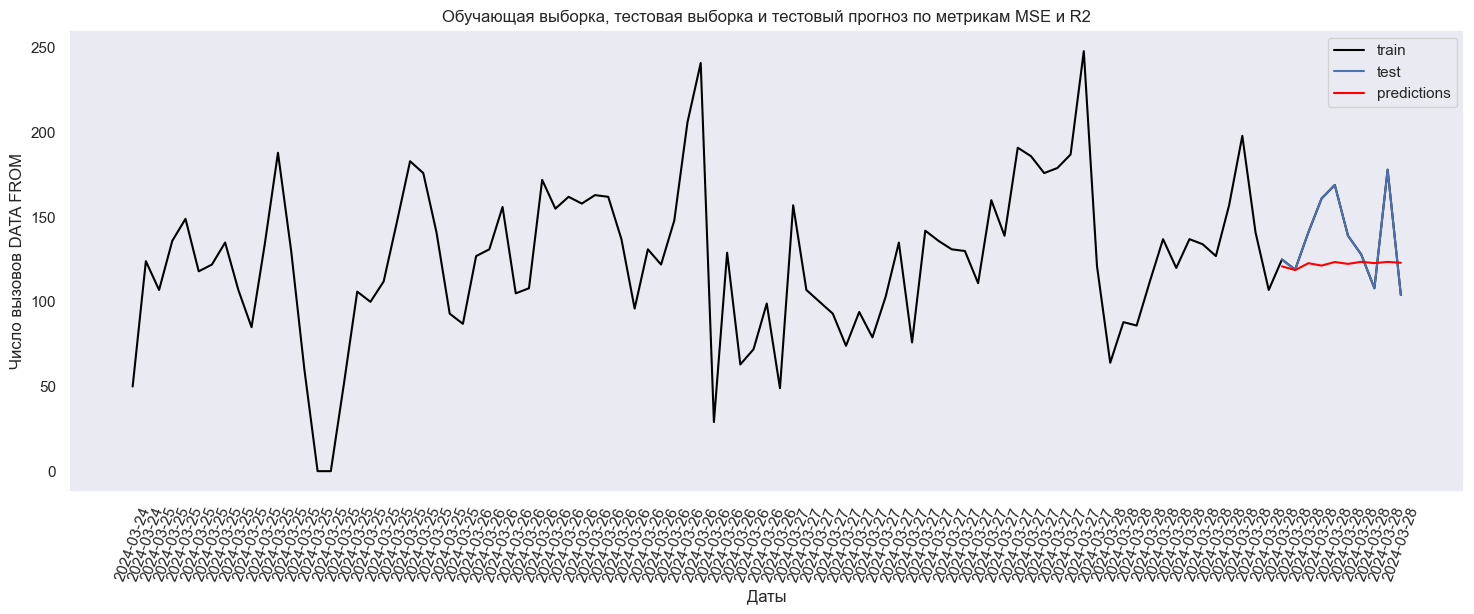

In [28]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика 

plt.plot(resampled_data_from, color='black', label='train') # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_from, label='test') # строим график тестовой выборки
plt.plot(predictions_from_mse_r2, color='red', label='predictions') # строим график предсказаний


# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрикам MSE и R2') # подписываем график
plt.legend() # добавляем легенду к графику
plt.ylabel('Число вызовов DATA FROM') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось Y
plt.xticks(resampled_data_from.index, rotation=70) # задаем размер для подписи значений на оси X
plt.grid() # cтроим график

plt.show() # выводим график на экран

### Модель с лучшим MAE

Создаем модель с параметрами, которые дали лучшее значение метрики MAE. Описывать действи с другими моделями не буду, принцип работы точь-в-точь такой же

In [29]:
model_from_best_mae = ARIMA(train_from, order=(0, 1, 12)) # создаем модель с определенными параметрами
model_from_best_mae = model_from_best_mae.fit() # обучаем модель

In [30]:
start = len(train_from) # задаем количество значений для старта обучения
end = len(train_from) + len(test_from) - 1 # задаем значение для конца обучения

# делаем предсказание и выводим первые 5 на экран
predictions_from_mae = model_from_best_mae.predict(start, end) # делаем предсказание модели
predictions_from_mae.index = test_from.index # сохраняем все значения 
predictions_from_mae.head() # выводим первые пять значений предсказаний

Дата
2024-03-28 13:00:00    107.943525
2024-03-28 14:00:00    101.532968
2024-03-28 15:00:00    125.782278
2024-03-28 16:00:00    118.299504
2024-03-28 17:00:00    118.657380
Freq: H, Name: predicted_mean, dtype: float64

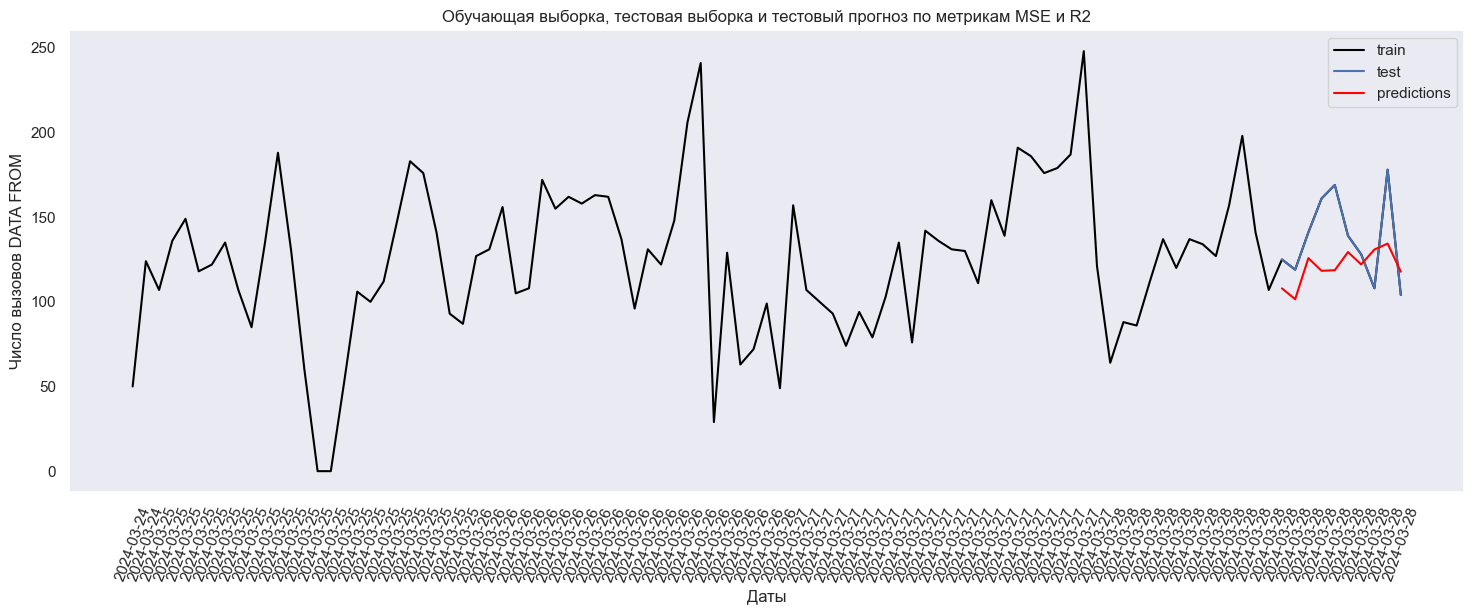

In [31]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика

plt.plot(resampled_data_from, color='black', label='train') # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_from, label='test') # строим график тестовой выборки
plt.plot(predictions_from_mae, color='red', label='predictions') # сторим график предсказаний

# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрикам MSE и R2') # задаем подпись графику
plt.legend() # добавляем легенду
plt.ylabel('Число вызовов DATA FROM') # добавляем подпись оси у
plt.xlabel('Даты') # добавляеи подпись оси х
plt.xticks(resampled_data_from.index, rotation=70) # добваляем значения на ось х
plt.grid() # объединяем графики

plt.show() # выводим график на экран

### Модель с лучшим MAPE

In [32]:
model_from_best_mape = ARIMA(train_from, order=(2, 0, 10)) # инициализируем модель с лучшими гиперпараметрами
model_from_best_mape = model_from_best_mape.fit() # обучаем модель

In [33]:
start = len(train_from) # задаем количество значений для старта обучения
end = len(train_from) + len(test_from) - 1 # задаем значение для конца обучения

# делаем предсказание и выводим первые 5 на экран
predictions_from_mape = model_from_best_mape.predict(start, end) # делаем предсказание модели
predictions_from_mape.index = test_from.index # сохраняем все значения 
predictions_from_mape.head() # выводим первые пять значений предсказаний

Дата
2024-03-28 13:00:00    101.306960
2024-03-28 14:00:00     97.379558
2024-03-28 15:00:00    116.382984
2024-03-28 16:00:00    107.973421
2024-03-28 17:00:00    108.244136
Freq: H, Name: predicted_mean, dtype: float64

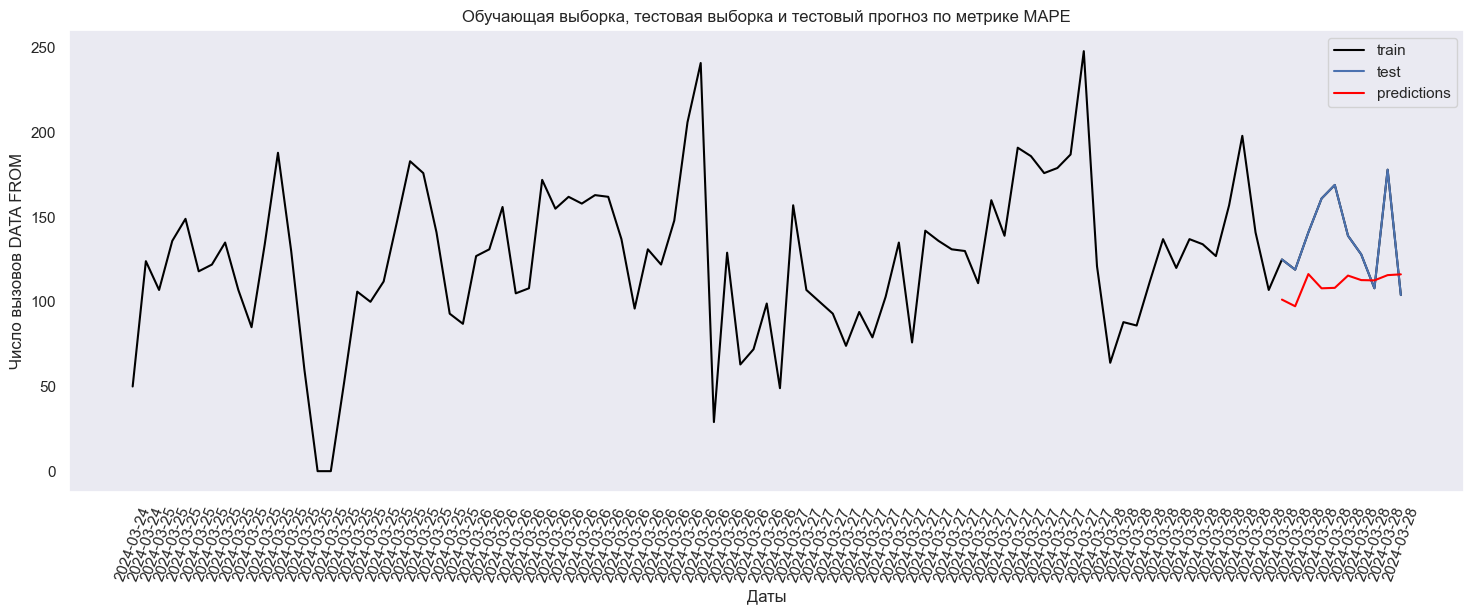

In [34]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика

plt.plot(resampled_data_from, color='black', label='train')  # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_from, label='test') # строим график тестовой выборки
plt.plot(predictions_from_mape, color='red', label='predictions')  # сторим график предсказаний

# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрике MAPE') # задаем подпись графику
plt.legend() # добавляем легенду
plt.ylabel('Число вызовов DATA FROM') # добавляем подпись оси у
plt.xlabel('Даты') # добавляеи подпись оси х
plt.xticks(resampled_data_from.index, rotation=70) # добваляем значения на ось х
plt.grid() # объединяем графики

plt.show() # выводим график на экран

## Вывод по DATA FROM

Исходя из графиков и данных, метрика R2 плохо подзодит для решния поставленной задачи, лучше вскго справилась модель подобранная по метрике MAPE - она сохраняет основыне спады и выбросы.

Лучшей моделью является модель ARIMA c параметрами p=2, d=0, q=10

# DATA TO

## EDA
На этом этапе ознакомимся с данными: узнаем размер датафрейма, проверим наличие полных дубликатов и пропусков.

In [35]:
data_to = pd.read_excel('/Users/matveyvolshchukov/Desktop/Done_Arima/2024_ИндЗаданиеARIMA/!Исходные данные за 4 дня/Данные для Арима ЛПЦ11/Шагающая_Балка/LPC_Step_B_Data_To.xlsx') # считываем таблицу в датафрейм
data_to.sample(5) # выводим 5 рандомных значений, чтобы убедиться что все считалось верно

,Дата,Куда
2549,24-03-28 06:03:36.113,НТА.М2.ШБ1.6 [x=634438.5 y=5922281.44 z=5.95]
5615,24-03-27 10:12:32.754,НТА.ШБ1.14 [x=634420.6 y=5922285.44 z=6.1]
12944,24-03-25 00:20:58.121,НТА.ШБ1.9 [x=634435.6 y=5922285.44 z=5.95]
2733,24-03-28 04:37:55.146,НТА.М1.ШБ1.2 [x=634442 y=5922278.04 z=5.95]
6193,24-03-27 04:38:43.625,НТА.М.ШБ1.8 [x=634440.3 y=5922285.44 z=5.95]


In [36]:
print("Размер датафрейма:", data_to.shape[0]) # получаем и выводим рзамер датафрейма

Размер датафрейма: 13167


In [37]:
print("Число полных дубликатов:", data_to.duplicated().sum()) # получаем и выводим количество дубликатов

Число полных дубликатов: 0


In [38]:
print("Количество пропусков в каждом столбце датафрейма: ") # выводим текст
data_to.isna().sum() # получаем и выводим количество пропусков в каждом столбце датафрейма

Количество пропусков в каждом столбце датафрейма: 


Дата    0
Куда    0
dtype: int64

In [39]:
data_to["Дата"] = pd.to_datetime(data_to["Дата"], format='%y-%m-%d %H:%M:%S.%f') # приводим дату к нужному формату
data_to.dtypes # выводим типы данных в датафрейме

Дата    datetime64[ns]
Куда            object
dtype: object

In [40]:
data_to['Куда'] = data_to['Куда'].str.replace(r'\[.*\]', '', regex=True).str.strip() # удаляем все координаты из второго столбца
data_to.head() # выводим датафрейм

,Дата,Куда
0,2024-03-28 22:36:46.629,НТА.ШБ1.15
1,2024-03-28 22:36:07.605,НТА.ШБ1.9
2,2024-03-28 22:35:37.627,НТА.ШБ2.17
3,2024-03-28 22:35:30.612,НТА.М.ШБ1.8
4,2024-03-28 22:34:56.603,НТА.М2.ШБ1.6


## Ресемплирование и вывод графиков
Так как нам дано мало данных, а модели необходимо на чем-то обучаться ресемплируем датафрейм по одному часу. После чего приведем дату к формату datetime и сделаем ее индексам (так принято при работе со временными рядами). На всякий случаем отсортируем индексы, чтобы дата и время шли по порядку.

После по всем данным построим график со скользящим средним и стандартным отклонением. Проведем тест на стационарность.

In [41]:
data_to.set_index('Дата', inplace=True) # делаем дату индексом нашего датафрейма (теперь это объект сериес, но для удобства я продолжу называть его датафреймом - разницы особой нет)
data_to = data_to.sort_index() # сортируем индексы, чтобы даты шли по порядку

resampled_data_to = data_to['Куда'].resample('1H').apply(lambda x: len(x)) # ресемлируем данные по одному часу и считаем количество вызовов кранов за час
resampled_data_to.head() # выводим первые пять элементов, чтобы знать как выглядит датафрейм сейчас

Дата
2024-03-24 22:00:00     55
2024-03-24 23:00:00    133
2024-03-25 00:00:00    114
2024-03-25 01:00:00    146
2024-03-25 02:00:00    160
Freq: H, Name: Куда, dtype: int64

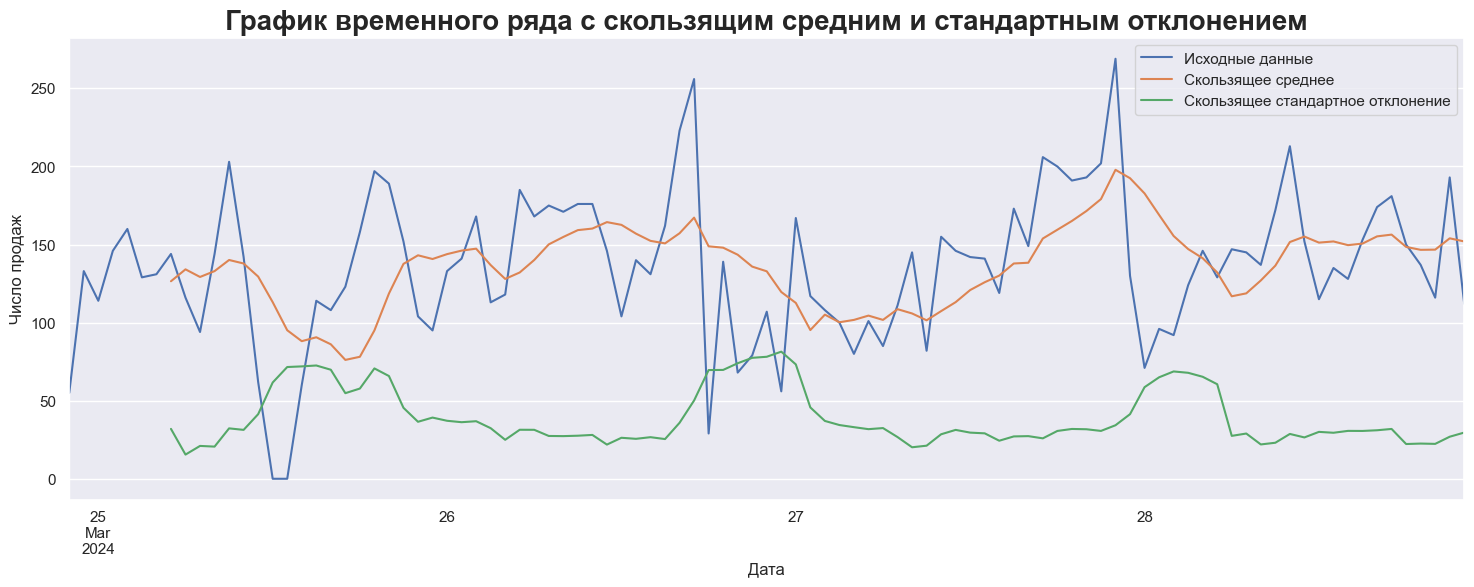

In [42]:
rolling_mean = resampled_data_to.rolling(window=8).mean() # создаем скользящее среднее с окном 8
rolling_std = resampled_data_to.rolling(window=8).std() # создаем скользящее стандартрное отклонение с окном 8

fig, ax = plt.subplots(figsize=(18, 6)) # задаем размер графика 
ax.set_title('График временного ряда с скользящим средним и стандартным отклонением', fontdict={'fontsize': 20, 'fontweight': 'bold'}) # подписываем график и задаем шрифт
ax.set_xlabel('Месяца', fontsize=12) # подписываем ось X
ax.set_ylabel('Число продаж', fontsize=12) # подписываем ось Y

resampled_data_to.plot(ax=ax, label='Исходные данные') # строим график по исходным данным

rolling_mean.plot(ax=ax, label='Скользящее среднее') # строим график скользящего стреднего

rolling_std.plot(ax=ax, label='Скользящее стандартное отклонение') # строим график скользящего стандартного отклонения

plt.legend() # добавляем легенду на график
plt.show() # выдоим графки на экран

Проведем тест, на стационарность данных, для этого выдвенем две гипотезы:
- **H0** - верменной ряд не является стационарным
- **H1** - временной ряд стационарен
   
Для проверки гипотезы будем использовать тест Дики-Фуллера

In [43]:
alpha = 0.05 # задаем пороговове значение (оно стандартное)
adf_test = adfuller(resampled_data_to.values) # проводим тест на наших данных

print('p-value = ', str(adf_test[1])) # выводим p-занчение проверям, выше или ниже оно нашего порогового значения

if adf_test[1] > alpha: # если p-value больше альфа принимаем гипотезу, иначе отвергаем
    print('Принимаем нулевую гипотезу') # выводим текст о принятии
else:
    print('Отвергаем нулевую гипотезу') # выводим текст о отвержении гипотезы

p-value =  1.7191996988257767e-07
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу, из чего можем предположить, что ряд является стационарным и не требует дифференцирования

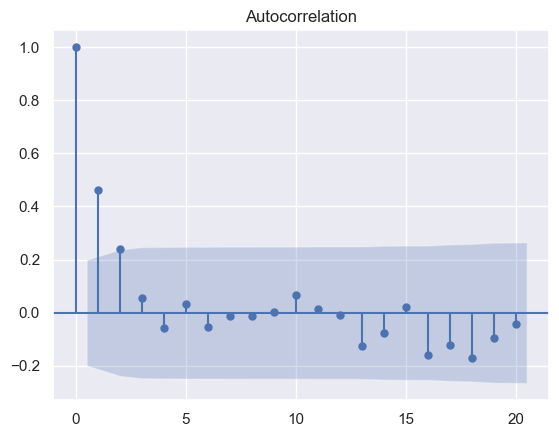

In [44]:
plot_acf(resampled_data_to) # создаем график ACF
plt.axis('tight') # задаем параметры необходимые для вывода
plt.show() # выводим график

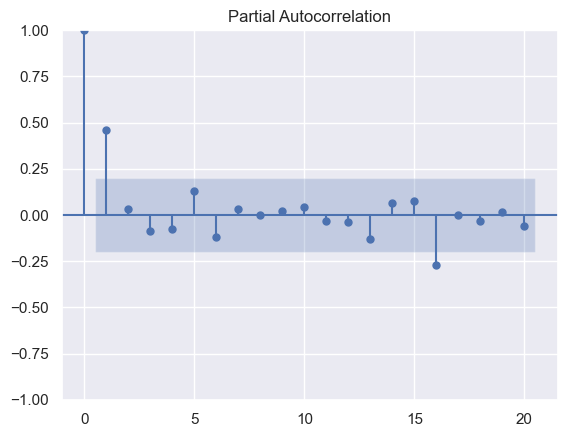

In [45]:
plot_pacf(resampled_data_to, method='ywm') # создаем график PACF с необходимыми параметрами
plt.show() # выводим график на экран

## Обучение модели DATA TO
Протестируем модель на четырех метриках, потом по графикам выберем модель которая предсказывает данные лучше всего.

In [46]:
alpha = int(len(resampled_data_to) * 0.9) # задаеим процент данных который войдет в тестовую и тренировочную выборку
train_to = resampled_data_to[:alpha] # задаем тренировочную выборку (90% данных)
test_to = resampled_data_to[alpha:] # задаем тестовую выборку (10% от данных)

In [47]:
train_to.tail() # выводим последние 5 значений тестовой выборки

Дата
2024-03-28 08:00:00    137
2024-03-28 09:00:00    172
2024-03-28 10:00:00    213
2024-03-28 11:00:00    152
2024-03-28 12:00:00    115
Freq: H, Name: Куда, dtype: int64

In [48]:
test_to.head() # выводим первые 5 значений тренировочной выборки 

Дата
2024-03-28 13:00:00    135
2024-03-28 14:00:00    128
2024-03-28 15:00:00    153
2024-03-28 16:00:00    174
2024-03-28 17:00:00    181
Freq: H, Name: Куда, dtype: int64

## Подбор параметров по метрикам

In [49]:
parameters = {'p': range(0, 3), 'd': range(0, 2), 'q': range(0, 16)} # задаем перебор параметров

# создаем массивы в которых будем хранить метрики
met_mse = [] # массив для метрик MSE
met_mae = [] # массив для метрик MAE
met_r2 = [] # массив для метрик R2
met_mape = [] # массив для метрик MAPE

for params in ParameterGrid(parameters): # задаем перебор параметров
    try: # если параметры можно подставить
        model = ARIMA(train_to, order=(params['p'], params['d'], params['q'])) # подставляем параметры в модель
        model_fit = model.fit() # обучаем модель

        predictions = model_fit.forecast(steps=len(test_to)) # деалаем предсказание
         # получаем результат MSE и добавляем его в массив
        metric_mse = mean_squared_error(test_to, predictions) # получаем значение метрики MSE
        met_mse.append((params, metric_mse)) # кладем значение метрики и параметры модели в массив

        # получаем резльтат MAE и добавляем его в массив

        metric_mae = mean_absolute_error(test_to, predictions) # получаем значение метрики MAE
        met_mae.append((params, metric_mae)) # кладем значение метрики и параметры модели в массив 

        # получаем резльтат R2 и добавляем его в массив
        metric_r2 = r2_score(test_to, predictions) # получаем значение метрики R2
        met_r2.append((params, metric_r2)) # кладем значение метрики и параметры модели в массив 

        # получаем резльтат MAPE и добавляем его в массив
        metric_mape = mean_absolute_percentage_error(test_to, predictions) # получаем значение метрики MAPE
        met_mape.append((params, metric_mape)) # кладем значение метрики и параметры модели в массив 
    except: # если подставить значение в модель не удалось и код выдал ошибку, пропускаеи и идем дальше 
        continue # оператор для перехода на следующую итерацию

In [50]:
# выводим лучшие метрики и их параметры
print(f'MSE: {min(met_mse, key=lambda x: x[1])}') # выводим лучшую метрику MSE
print(f'MAE: {min(met_mae, key=lambda x: x[1])}') # выводим лучшую метрику MAE
print(f'R2: {max(met_r2, key=lambda x: x[1])}') # выводим лучшую метрику R2
print(f'MAPE: {min(met_mape, key=lambda x: x[1])}') # выводим лучшую метрику MAPE

MSE: ({'d': 1, 'p': 1, 'q': 3}, 697.1775952418868)
MAE: ({'d': 1, 'p': 1, 'q': 3}, 21.4656602885969)
R2: ({'d': 1, 'p': 1, 'q': 3}, -0.020922249911240254)
MAPE: ({'d': 1, 'p': 1, 'q': 3}, 0.14215900025814618)


По метрикам MSE, MAE и R2 получились одинаковые параметры p, d, q.

### Модель с лчшими MSE, MAE и R2

In [51]:
model_mse_mae_r2 = ARIMA(train_to, order=(0, 1, 12)) # задаем модель с лучшими параметрами для метрик MAE и R2
model_mse_mae_r2 = model_mse_mae_r2.fit() # обучаем модель

In [52]:
# делаем предсказания и выводим их на экран
predictions_mse_mae_r2 = model_mse_mae_r2.predict(start, end) # получаем предсказания
predictions_mse_mae_r2.index = test_to.index # зпаисываем предсказания в датафрейм для хранения
predictions_mse_mae_r2.head() # выводим первые пять строк предсказаний

Дата
2024-03-28 13:00:00    114.715753
2024-03-28 14:00:00    109.785591
2024-03-28 15:00:00    135.653989
2024-03-28 16:00:00    128.441839
2024-03-28 17:00:00    128.956138
Freq: H, Name: predicted_mean, dtype: float64

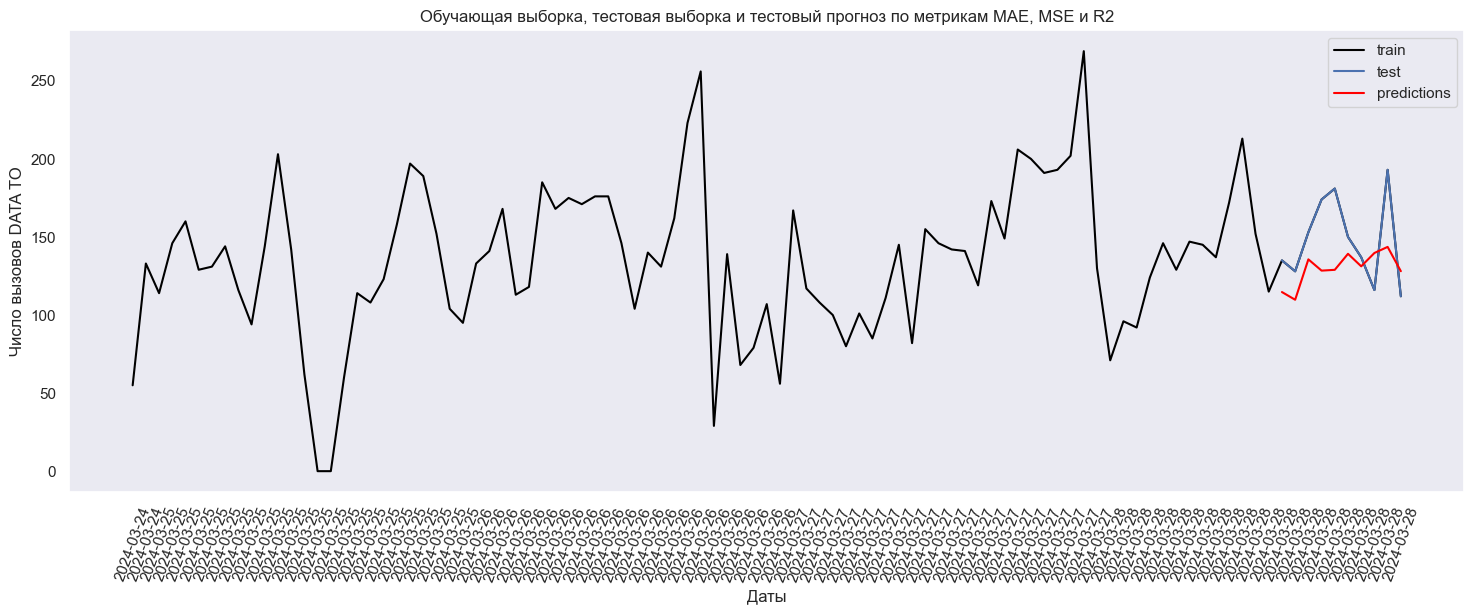

In [53]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика 

plt.plot(resampled_data_to, color='black', label='train') # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_to, label='test') # строим график тестовой выборки
plt.plot(predictions_mse_mae_r2, color='red', label='predictions') # строим график предсказаний

# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрикам MAE, MSE и R2') # подписываем график
plt.legend() # добавляем легенду к графику
plt.ylabel('Число вызовов DATA TO') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось Y
plt.xticks(resampled_data_to.index, rotation=70) # задаем размер для подписи значений на оси X
plt.grid() # cтроим график

plt.show() # выводим график на экран

### Модель с лучшим MAPE

In [54]:
model_mape = ARIMA(train_to, order=(0, 0, 10)) # задаем модель с лучшими параметрами для метрик MAPE
model_mape = model_mape.fit() # обучаем модель

In [55]:
# делаем предсказания и выводим их на экран
predictions_mape = model_mape.predict(start, end) # получаем предсказания
predictions_mape.index = test_to.index # зпаисываем предсказания в датафрейм для хранения
predictions_mape.head() # выводим первые пять строк предсказаний

Дата
2024-03-28 13:00:00    111.498495
2024-03-28 14:00:00    109.913846
2024-03-28 15:00:00    133.533753
2024-03-28 16:00:00    128.111933
2024-03-28 17:00:00    127.948463
Freq: H, Name: predicted_mean, dtype: float64

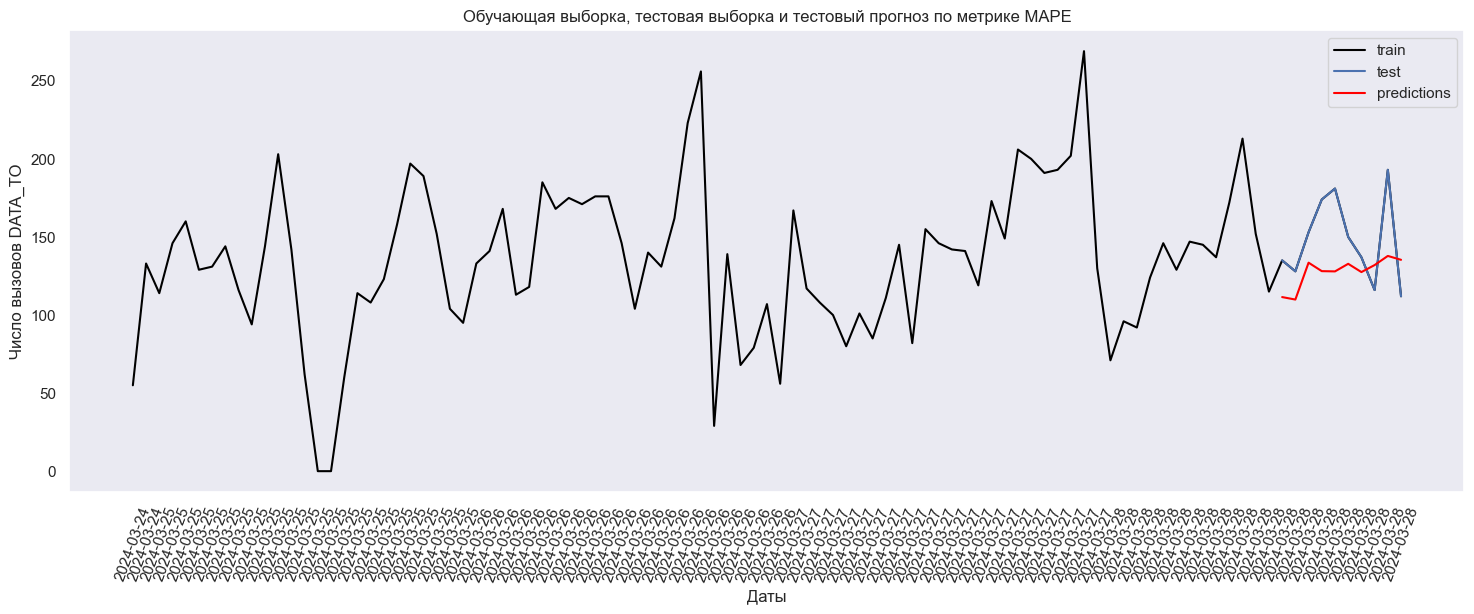

In [56]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика

plt.plot(resampled_data_to, color='black', label='train') # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_to, label='test') # строим график тестовой выборки
plt.plot(predictions_mape, color='red', label='predictions') # строим график предсказаний

# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрике MAPE') # подписываем график
plt.legend() # добавляем легенду к графику
plt.ylabel('Число вызовов DATA_TO') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось Y
plt.xticks(resampled_data_to.index, rotation=70) # задаем размер для подписи значений на оси X
plt.grid() # cтроим график

plt.show() # выводим график на экран

## Вывод по DATA TO

Лучшей моделью является модель ARIMA подобранная на метриках MSE, MAE и R2 (r2 скорее всего плохо подходит для этой задачи) c параметрами p=0, d=1, q=12; так как она немного лучше сохраняет лучше выбросы в данных

# ID
## EDA
На этом этапе ознакомимся с данными: узнаем размер датафрейма, проверим наличие полных дубликатов и пропусков.

In [57]:
data_id = pd.read_excel('/Users/matveyvolshchukov/Desktop/Done_Arima/2024_ИндЗаданиеARIMA/!Исходные данные за 4 дня/Данные для Арима ЛПЦ11/Шагающая_Балка/LPC_Step_B_Data_ID.xlsx') # считываем таблицу в датафрейм
data_id.sample(5) # выводим 5 рандомных значений, чтобы убедиться что все считалось верно

,Дата,ID
9713,24-03-26 02:37:55.644,64620
11337,24-03-25 14:59:27.767,64443
7686,24-03-26 16:00:23.130,64810
9758,24-03-26 02:21:01.626,64622
1373,24-03-28 13:46:32.641,65502


In [58]:
print("Размер датафрейма:", data_id.shape[0]) # получаем и выводим рзамер датафрейма

Размер датафрейма: 13167


In [59]:
print("Число полных дубликатов:", data_id.duplicated().sum()) # получаем и выводим количество дубликатов

Число полных дубликатов: 0


In [60]:
print("Количество пропусков в каждом столбце датафрейма: ") # выводим текст
data_id.isna().sum() # получаем и выводим количество пропусков в каждом столбце датафрейма

Количество пропусков в каждом столбце датафрейма: 


Дата    0
ID      0
dtype: int64

In [61]:
data_id["Дата"] = pd.to_datetime(data_id["Дата"], format='%y-%m-%d %H:%M:%S.%f') # приводим дату к нужному формату
data_id.dtypes # выводим типы данных в датафрейме

Дата    datetime64[ns]
ID               int64
dtype: object

## Ресемплирование и вывод графиков
Так как нам дано мало данных, а модели необходимо на чем-то обучаться ресемплируем датафрейм по одному часу. После чего приведем дату к формату datetime и сделаем ее индексам (так принято при работе со временными рядами). На всякий случаем отсортируем индексы, чтобы дата и время шли по порядку.

После по всем данным построим график со скользящим средним и стандартным отклонением. Проведем тест на стационарность.

In [62]:
data_id.set_index('Дата', inplace=True) # делаем дату индексом нашего датафрейма (теперь это объект сериес, но для удобства я продолжу называть его датафреймом - разницы особой нет)
data_id = data_id.sort_index() # сортируем индексы, чтобы даты шли по порядку

resampled_data_id = data_id['ID'].resample('1H').apply(lambda x: len(x)) # ресемлируем данные по одному часу и считаем количество вызовов кранов за час
resampled_data_id.head() # выводим первые пять элементов, чтобы знать как выглядит датафрейм сейчас

Дата
2024-03-24 22:00:00     55
2024-03-24 23:00:00    133
2024-03-25 00:00:00    114
2024-03-25 01:00:00    146
2024-03-25 02:00:00    160
Freq: H, Name: ID, dtype: int64

In [63]:
resampled_data_id.head()

Дата
2024-03-24 22:00:00     55
2024-03-24 23:00:00    133
2024-03-25 00:00:00    114
2024-03-25 01:00:00    146
2024-03-25 02:00:00    160
Freq: H, Name: ID, dtype: int64

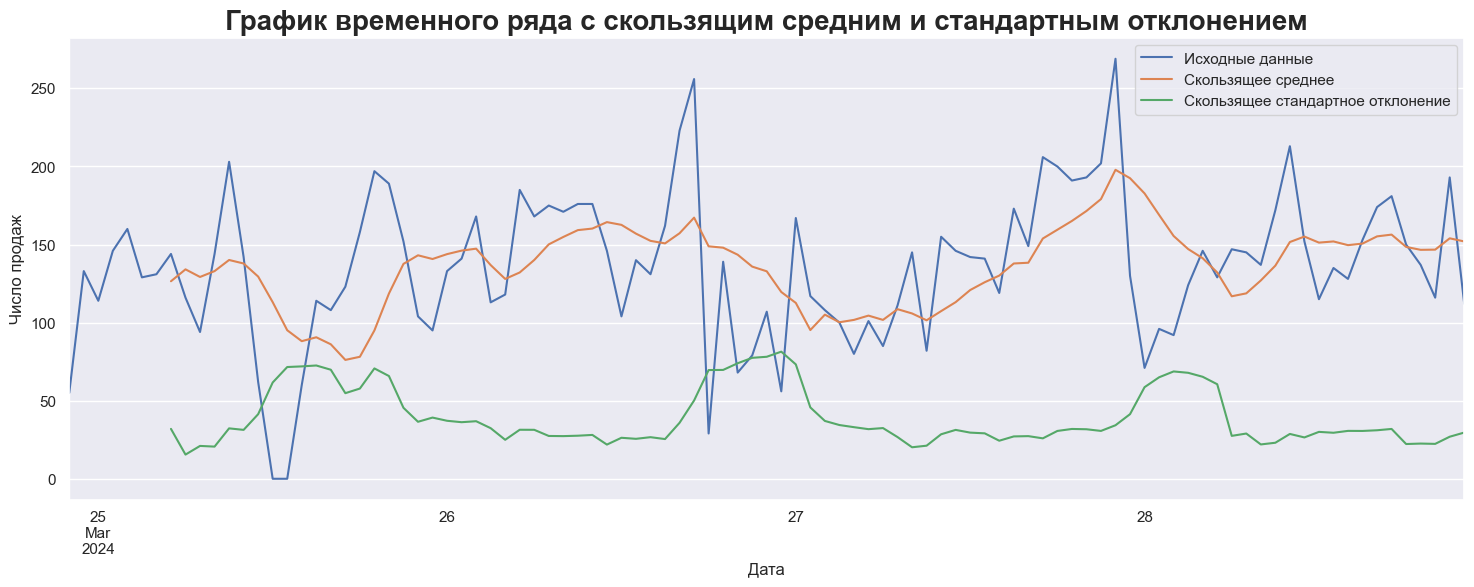

In [64]:
rolling_mean = resampled_data_id.rolling(window=8).mean() # создаем скользящее среднее с окном 8
rolling_std = resampled_data_id.rolling(window=8).std() # создаем скользящее стандартрное отклонение с окном 8

fig, ax = plt.subplots(figsize=(18, 6)) # задаем размер графика 
ax.set_title('График временного ряда с скользящим средним и стандартным отклонением', fontdict={'fontsize': 20, 'fontweight': 'bold'}) # подписываем график и задаем шрифт
ax.set_xlabel('Месяца', fontsize=12) # подписываем ось X
ax.set_ylabel('Число продаж', fontsize=12) # подписываем ось Y

resampled_data_id.plot(ax=ax, label='Исходные данные') # строим график по исходным данным

rolling_mean.plot(ax=ax, label='Скользящее среднее') # строим график скользящего стреднего

rolling_std.plot(ax=ax, label='Скользящее стандартное отклонение') # строим график скользящего стандартного отклонения

plt.legend() # добавляем легенду на график
plt.show() # выдоим графки на экран

Проведем тест, на стационарность данных, для этого выдвенем две гипотезу:
- **H0** - верменной ряд не является стационарным
- **H1** - временной ряд стационарен
   
Для проверки гипотезы будем использовать тест Дики-Фуллера

In [65]:
alpha = 0.05 # задаем пороговове значение (оно стандартное)
adf_test = adfuller(resampled_data_id.values) # проводим тест на наших данных

print('p-value = ', str(adf_test[1])) # выводим p-занчение проверям, выше или ниже оно нашего порогового значения

if adf_test[1] > alpha: # если p-value больше альфа принимаем гипотезу, иначе отвергаем
    print('Принимаем нулевую гипотезу') # выводим текст о принятии
else:
    print('Отвергаем нулевую гипотезу') # выводим текст о отвержении гипотезы

p-value =  1.7191996988257767e-07
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу, из чего можем предположить, что ряд является стационарным и не требует дифференцирования

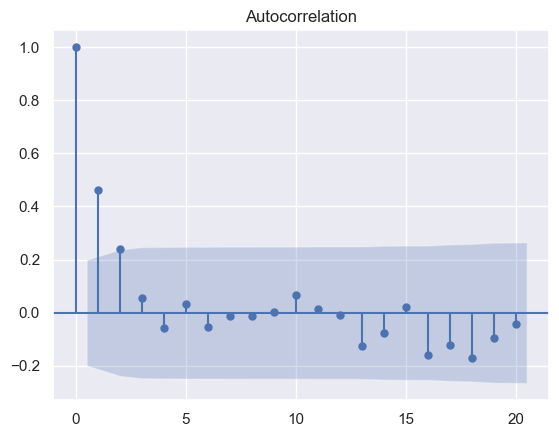

In [66]:
plot_acf(resampled_data_id) # создаем график ACF
plt.axis('tight') # задаем параметры необходимые для вывода
plt.show() # выводим график

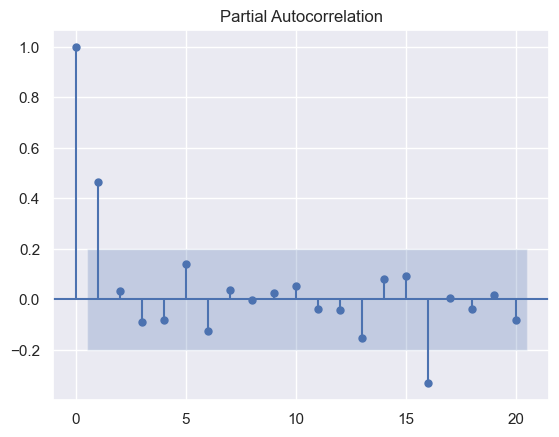

In [67]:
plot_pacf(resampled_data_id) # создаем график PACF с необходимыми параметрами
plt.axis('tight') # задаем параметры необходимые для вывода
plt.show() # выводим график на экран

## Обучение модели ID
Протестируем модель на четырех метриках, потом по графикам выберем модель которая предсказывает данные лучше всего.

In [68]:
alpha = int(len(resampled_data_id) * 0.9) # задаеим процент данных который войдет в тестовую и тренировочную выборку
train_id = resampled_data_id[:alpha] # задаем тренировочную выборку (90% данных)
test_id = resampled_data_id[alpha:] # задаем тестовую выборку (10% данных)

In [69]:
train_id.tail() # выводим последние 5 значений тестовой выборки

Дата
2024-03-28 08:00:00    137
2024-03-28 09:00:00    172
2024-03-28 10:00:00    213
2024-03-28 11:00:00    152
2024-03-28 12:00:00    115
Freq: H, Name: ID, dtype: int64

In [70]:
test_id.head() # выводим первые 5 значений тренировочной выборки

Дата
2024-03-28 13:00:00    135
2024-03-28 14:00:00    128
2024-03-28 15:00:00    153
2024-03-28 16:00:00    174
2024-03-28 17:00:00    181
Freq: H, Name: ID, dtype: int64

## Подбор параметров по метрикам

In [71]:
parameters = {'p': range(0, 4), 'd': range(0, 2), 'q': range(0, 16)} # задаем перебор параметров
# создаем массивы в которых будем хранить метрики
met_mse = [] # массив для метрик MSE
met_mae = [] # массив для метрик MAE
met_r2 = [] # массив для метрик R2
met_mape = [] # массив для метрик MAPE

for params in ParameterGrid(parameters): # задаем перебор параметров
    try: # если параметры можно подставить
        model = ARIMA(train_id, order=(params['p'], params['d'], params['q'])) # подставляем параметры в модель
        model_fit = model.fit() # обучаем модель

        predictions = model_fit.forecast(steps=len(test_id)) # деалаем предсказание
         # получаем результат MSE и добавляем его в массив
        metric_mse = mean_squared_error(test_id, predictions) # получаем значение метрики MSE
        met_mse.append((params, metric_mse)) # кладем значение метрики и параметры модели в массив

        # получаем резльтат MAE и добавляем его в массив
        metric_mae = mean_absolute_error(test_id, predictions) # получаем значение метрики MAE
        met_mae.append((params, metric_mae)) # кладем значение метрики и параметры модели в массив 

        # получаем резльтат R2 и добавляем его в массив
        metric_r2 = r2_score(test_id, predictions) # получаем значение метрики R2
        met_r2.append((params, metric_r2)) # кладем значение метрики и параметры модели в массив 

        # получаем резльтат MAPE и добавляем его в массив
        metric_mape = mean_absolute_percentage_error(test_id, predictions) # получаем значение метрики MAPE
        met_mape.append((params, metric_mape)) # кладем значение метрики и параметры модели в массив 
    except:
        continue

In [72]:
# выводим лучшие метрики и их параметры
print(f'MSE: {min(met_mse, key=lambda x: x[1])}') # выводим лучшую метрику MSE
print(f'MAE: {min(met_mae, key=lambda x: x[1])}') # выводим лучшую метрику MAE
print(f'R2: {max(met_r2, key=lambda x: x[1])}') # выводим лучшую метрику R2
print(f'MAPE: {min(met_mape, key=lambda x: x[1])}') # выводим лучшую метрику MAPE

MSE: ({'d': 1, 'p': 1, 'q': 3}, 697.1775952418868)
MAE: ({'d': 1, 'p': 1, 'q': 3}, 21.4656602885969)
R2: ({'d': 1, 'p': 1, 'q': 3}, -0.020922249911240254)
MAPE: ({'d': 1, 'p': 1, 'q': 3}, 0.14215900025814618)


По метрикам MSE и R2 получились одинаковые параметры p, d, q. По метрикам MAE и MAPE тоже получились одинаковые параметры p, d, q.

### Модель с лучшими MSE и R2

In [73]:
model_mse_r2 = ARIMA(train_id, order=(3, 1, 2)) # задаем модель с лучшими параметрами для метрик MSE и R2
model_mse_r2 = model_mse_r2.fit() # обучаем модель

In [74]:
# делаем предсказания и выводим их на экран
predictions_mse_r2 = model_mse_r2.predict(start, end) # получаем предсказания
predictions_mse_r2.index = test_id.index # зпаисываем предсказания в датафрейм для хранения
predictions_mse_r2.head() # выводим первые пять строк предсказаний

Дата
2024-03-28 13:00:00    129.514886
2024-03-28 14:00:00    128.207513
2024-03-28 15:00:00    132.086363
2024-03-28 16:00:00    131.145027
2024-03-28 17:00:00    133.068536
Freq: H, Name: predicted_mean, dtype: float64

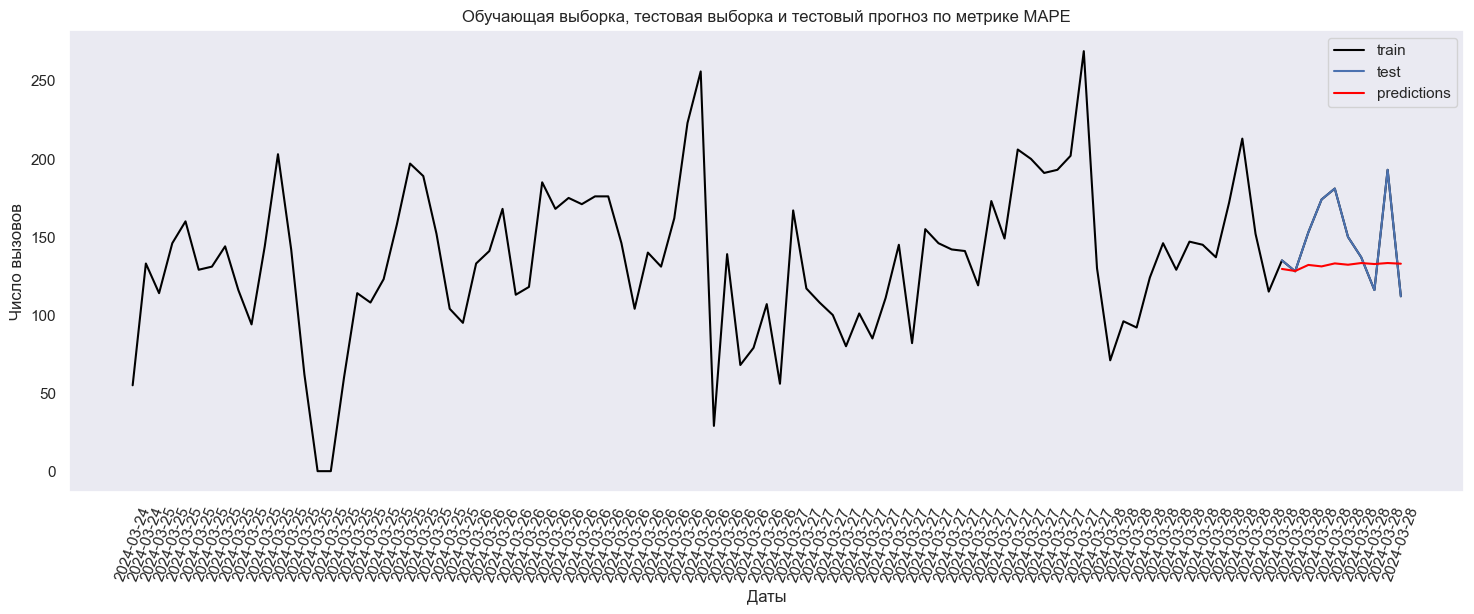

In [75]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика 

plt.plot(resampled_data_id, color='black', label='train') # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_id, label='test') # строим график тестовой выборки
plt.plot(predictions_mse_r2, color='red', label='predictions') # строим график предсказаний

# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрике MAPE') # подписываем график
plt.legend() # добавляем легенду к графику
plt.ylabel('Число вызовов') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось Y
plt.xticks(resampled_data_id.index, rotation=70) # задаем размер для подписи значений на оси X
plt.grid() # cтроим график

plt.show() # выводим график на экран

### Модель с лучшими MAE и MAPE

In [76]:
model_mae_mape = ARIMA(train_id, order=(3, 0, 10)) # задаем модель с лучшими параметрами для метрик MAE и MAPE
model_mae_mape = model_mae_mape.fit() # обучаем модель

In [77]:
# делаем предсказания и выводим их на экран
predictions_mae_mape = model_mae_mape.predict(start, end)  # получаем предсказания
predictions_mae_mape.index = test_id.index # зпаисываем предсказания в датафрейм для хранения
predictions_mae_mape.head() # выводим первые пять строк предсказаний

Дата
2024-03-28 13:00:00    118.971635
2024-03-28 14:00:00    107.900092
2024-03-28 15:00:00    135.845409
2024-03-28 16:00:00    131.244615
2024-03-28 17:00:00    120.795508
Freq: H, Name: predicted_mean, dtype: float64

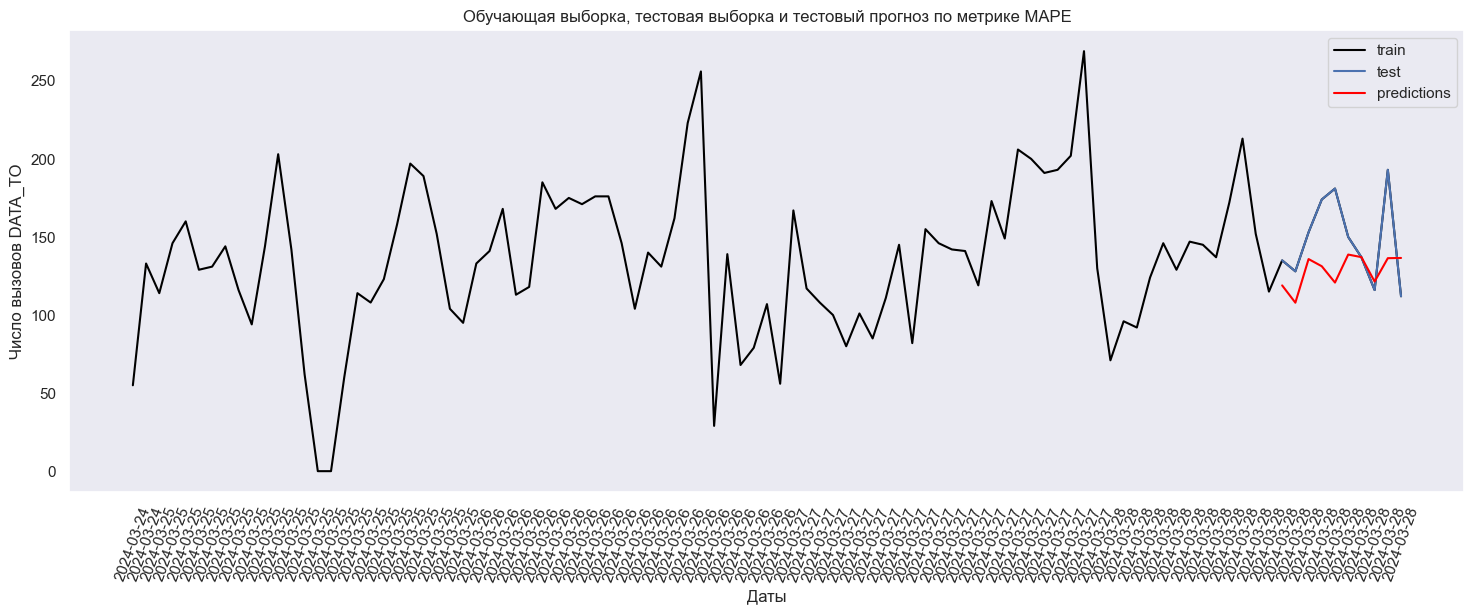

In [78]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика 

plt.plot(resampled_data_id, color='black', label='train') # строим график тренировочной выборки, красим его в черный и добавляем легенду
plt.plot(test_id, label='test') # строим график тестовой выборки
plt.plot(predictions_mae_mape, color='red', label='predictions') # строим график предсказаний

# задаем подписи к графику
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз по метрике MAPE') # подписываем график
plt.legend() # добавляем легенду к графику
plt.ylabel('Число вызовов DATA_TO') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось Y
plt.xticks(resampled_data_id.index, rotation=70) # задаем размер для подписи значений на оси X
plt.grid() # cтроим график

plt.show() # выводим график на экран

## Вывод по DATA ID

Лучшей моделью является модель ARIMA подобранная на метриках MAE и MAPE c параметрами p=3, d=0, q=10; так как она немного лучше сохраняет выбросы в данных

# Предсказание лучшей модели на будущее
Обучем модель на всех данных, а предсказания будем делать по сгенерированным датам
## DATA FROM

In [79]:
# генерируем даты
start_date = '2024-03-28 22:00:00' # новая дата и время, которых не было в исходном датафрейме (нашачло)
end_date =  '2024-03-29 18:00:00' # ... (конец)

# создаем новые индексы для предсказания, с шагом в 1 час с даты начала по дату конца
train_from = resampled_data_from[:-1] # сохраняем в тренировочную выборку все значения кроме послденего
test_from = pd.DataFrame({'Дата' : pd.date_range(start=start_date, end=end_date, freq='H')}).set_index('Дата') # генерируем даты с шагом в один час и добавляем их в тестовую выборку

test_from.head() # выводим на экран для проверки

""
Дата
2024-03-28 22:00:00
2024-03-28 23:00:00
2024-03-29 00:00:00
2024-03-29 01:00:00
2024-03-29 02:00:00


In [80]:
model_from_best_mape = ARIMA(train_from, order=(2, 0, 10)) # создаем модель с лучшимим параметрами
model_from_best_mape = model_from_best_mape.fit() # обучаем модель

In [81]:
start = len(train_from) # задаем старт для предсказания
end = len(train_from) + len(test_from) - 1 # задаем конец для предсказания

# делаем предсказания
predictions_from_mape = model_from_best_mape.predict(start, end) # получаем предсказания модели
predictions_from_mape.index = test_from.index # cохраняем их в датафрейм для хранения

# добавляем предсказание в конец тренировочной выборки, чтобы график был без разрывов
new_row = pd.Series(data=[predictions_from_mape[0]], index=[pd.Timestamp('2024-03-28 22:00:00')]) # создаем новый DataFrame для вывода графиков тренировочной и тестовой выборок 
train_from = train_from.append(new_row) # добавляем к тренировочной выборке корректно сохраненные предсказания
train_from.tail() # выводи последние 5 значений на экран

2024-03-28 18:00:00    139.000000
2024-03-28 19:00:00    128.000000
2024-03-28 20:00:00    108.000000
2024-03-28 21:00:00    178.000000
2024-03-28 22:00:00    151.078121
dtype: float64

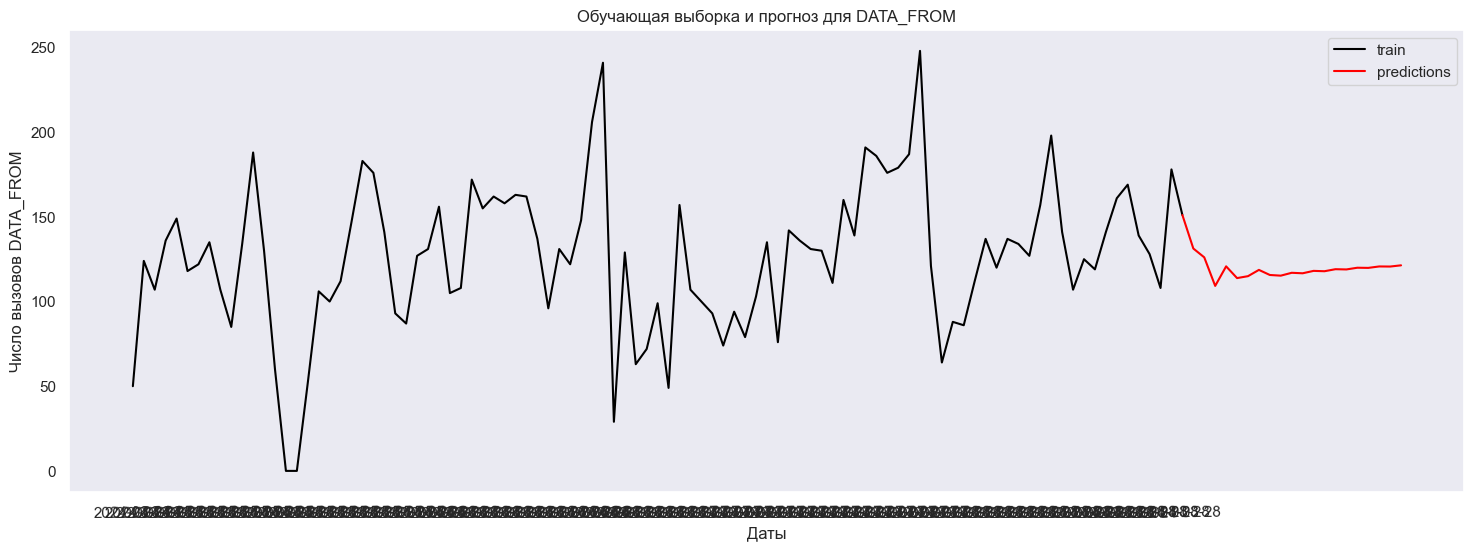

In [82]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика

plt.plot(train_from, color='black', label='train') # строим график тренировочноый выборки и красим его в черный
plt.plot(predictions_from_mape, color='red', label='predictions') # строим график предсказаний и красим его в красный

# добавляем подписи на график
plt.title('Обучающая выборка и прогноз для DATA_FROM') # подписываем график
plt.legend() # добавляем легенду
plt.ylabel('Число вызовов DATA_FROM') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось X
plt.xticks(train_from.index, rotation=1) # задаем интревалы для подписи значений на оси X
plt.grid() # созадем график

plt.show() # выводим график на экран

## DATA TO

In [83]:
# генерируем даты
start_date = '2024-03-28 22:00:00'  # новая дата и время, которых не было в исходном датафрейме (нашачло)
end_date =  '2024-03-29 18:00:00' # ... (конец)

# создаем новые индексы для предсказания, с шагом в 1 час с даты начала по дату конца
train_to = resampled_data_to[:-1] # сохраняем в тренировочную выборку все значения кроме послденего
test_to = pd.DataFrame({'Дата' : pd.date_range(start=start_date, end=end_date, freq='H')}).set_index('Дата') # генерируем даты с шагом в один час и добавляем их в тестовую выборку

test_to.head() # выводим на экран для проверки

""
Дата
2024-03-28 22:00:00
2024-03-28 23:00:00
2024-03-29 00:00:00
2024-03-29 01:00:00
2024-03-29 02:00:00


In [84]:
model_to_best_mae = ARIMA(train_to, order=(0, 1, 12)) # создаем модель с лучшимим параметрами
model_to_best_mae = model_to_best_mae.fit() # обучаем модель

In [85]:
start = len(train_to) # задаем старт для предсказания
end = len(train_to) + len(test_to) - 1 # задаем конец для предсказания

predictions_to_mae = model_to_best_mae.predict(start, end) # получаем предсказания модели
predictions_to_mae.index = test_to.index # cохраняем их в датафрейм для хранения

# добавляем предсказание в конец тренировочной выборки, чтобы график был без разрывов
new_row = pd.Series(data=[predictions_to_mae[0]], index=[pd.Timestamp('2024-03-28 22:00:00')]) # создаем новый DataFrame для вывода графиков тренировочной и тестовой выборок 
train_to = train_to.append(new_row) # добавляем к тренировочной выборке корректно сохраненные предсказания
train_to.tail() # выводи последние 5 значений на экран

2024-03-28 18:00:00    150.000000
2024-03-28 19:00:00    137.000000
2024-03-28 20:00:00    116.000000
2024-03-28 21:00:00    193.000000
2024-03-28 22:00:00    157.497671
dtype: float64

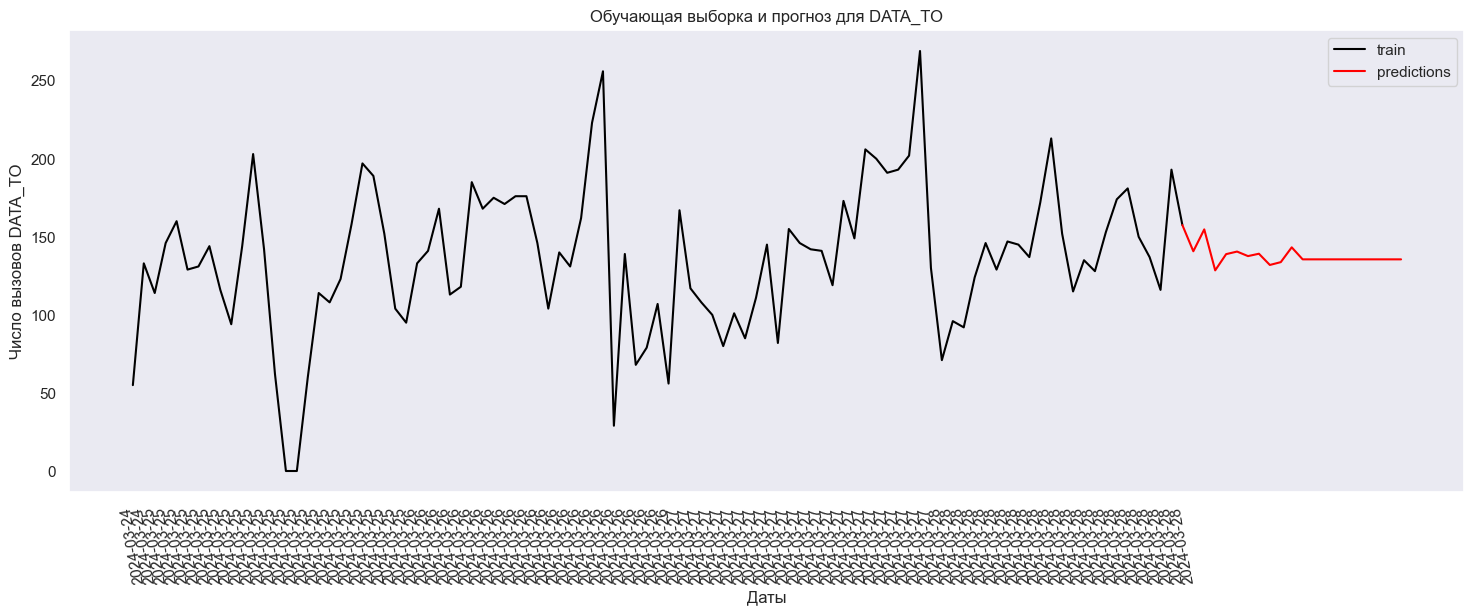

In [86]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика

plt.plot(train_to, color='black', label='train') # строим график тренировочноый выборки и красим его в черный
plt.plot(predictions_to_mae, color='red', label='predictions') # строим график предсказаний и красим его в красный

# добавляем подписи на график
plt.title('Обучающая выборка и прогноз для DATA_TO') # подписываем график
plt.legend() # добавляем легенду
plt.ylabel('Число вызовов DATA_TO') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось X
plt.xticks(train_to.index, rotation=100) # задаем интревалы для подписи значений на оси X
plt.grid() # созадем график

plt.show() # выводим график на экран

## ID

In [87]:
# генерируем даты
start_date = '2024-03-28 22:00:00' # новая дата и время, которых не было в исходном датафрейме (нашачло)
end_date =  '2024-03-29 18:00:00' # ... (конец)

# создаем новые индексы для предсказания, с шагом в 1 час с даты начала по дату конца
train_id = resampled_data_id[:-1] # сохраняем в тренировочную выборку все значения кроме послденего
test_id = pd.DataFrame({'Дата' : pd.date_range(start=start_date, end=end_date, freq='H')}).set_index('Дата') # генерируем даты с шагом в один час и добавляем их в тестовую выборку

test_id.head() # выводим на экран для проверки

""
Дата
2024-03-28 22:00:00
2024-03-28 23:00:00
2024-03-29 00:00:00
2024-03-29 01:00:00
2024-03-29 02:00:00


In [88]:
model_id_best_mae = ARIMA(train_id, order=(3, 0, 10)) # создаем модель с лучшимим параметрами
model_id_best_mae = model_id_best_mae.fit() # обучаем модель

In [89]:
start = len(train_id) # задаем старт для предсказания
end = len(train_id) + len(test_id) - 1 # задаем конец для предсказания

predictions_id_mae = model_id_best_mae.predict(start, end) # получаем предсказания модели
predictions_id_mae.index = test_id.index # cохраняем их в датафрейм для хранения

# добавляем предсказание в конец тренировочной выборки, чтобы график был без разрывов
new_row = pd.Series(data=[predictions_id_mae[0]], index=[pd.Timestamp('2024-03-28 22:00:00')]) # создаем новый DataFrame для вывода графиков тренировочной и тестовой выборок 
train_id = train_id.append(new_row) # добавляем к тренировочной выборке корректно сохраненные предсказания
train_id.tail() # выводи последние 5 значений на экран

2024-03-28 18:00:00    150.000000
2024-03-28 19:00:00    137.000000
2024-03-28 20:00:00    116.000000
2024-03-28 21:00:00    193.000000
2024-03-28 22:00:00    162.940644
dtype: float64

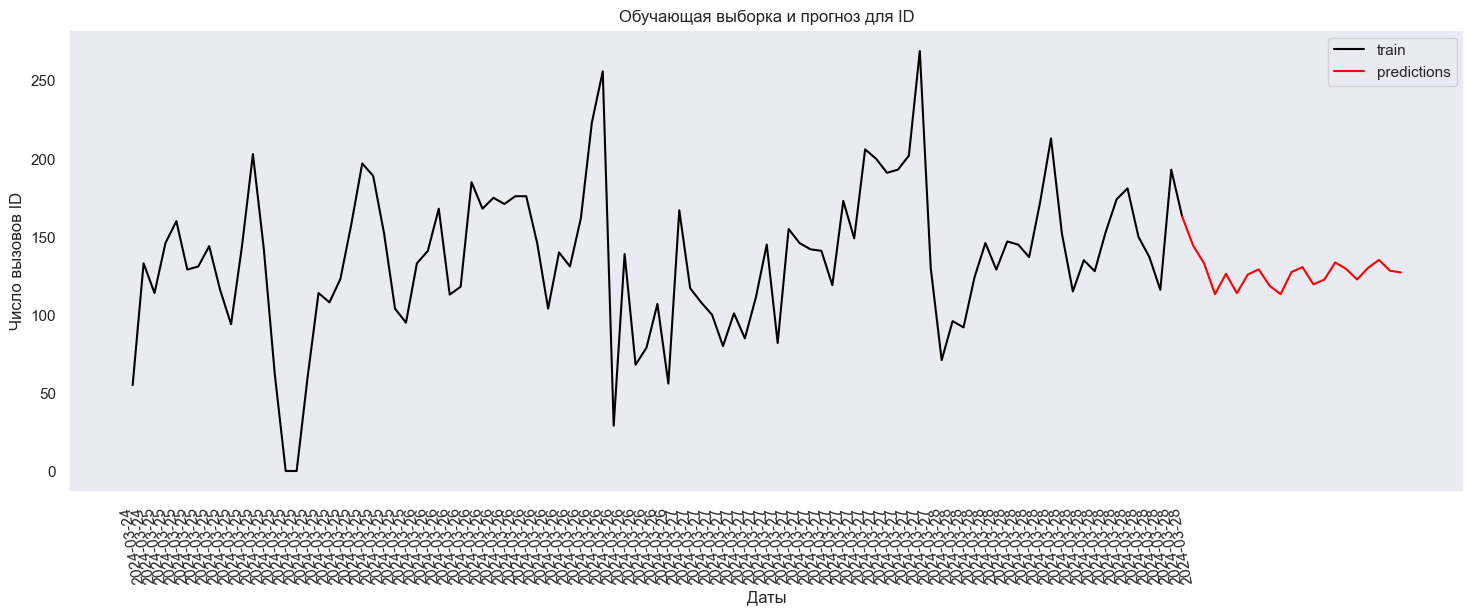

In [90]:
fig = plt.figure(figsize=(18, 6)) # задаем размер графика

plt.plot(train_id, color='black', label='train') # строим график тренировочноый выборки и красим его в черный
plt.plot(predictions_id_mae, color='red', label='predictions') # строим график предсказаний и красим его в красный

# добавляем подписи на график
plt.title('Обучающая выборка и прогноз для ID') # подписываем график
plt.legend() # добавляем легенду
plt.ylabel('Число вызовов ID') # подписываем ось Y
plt.xlabel('Даты') # подписываем ось X
plt.xticks(train_id.index, rotation=100) # задаем интревалы для подписи значений на оси X
plt.grid() # созадем график

plt.show() # выводим график на экран

# Гафик по всем данным

График объединяет в себе данные по всем таблицам (DATA_FROM, DATA_TO, ID) и предсказанные значения по ним.

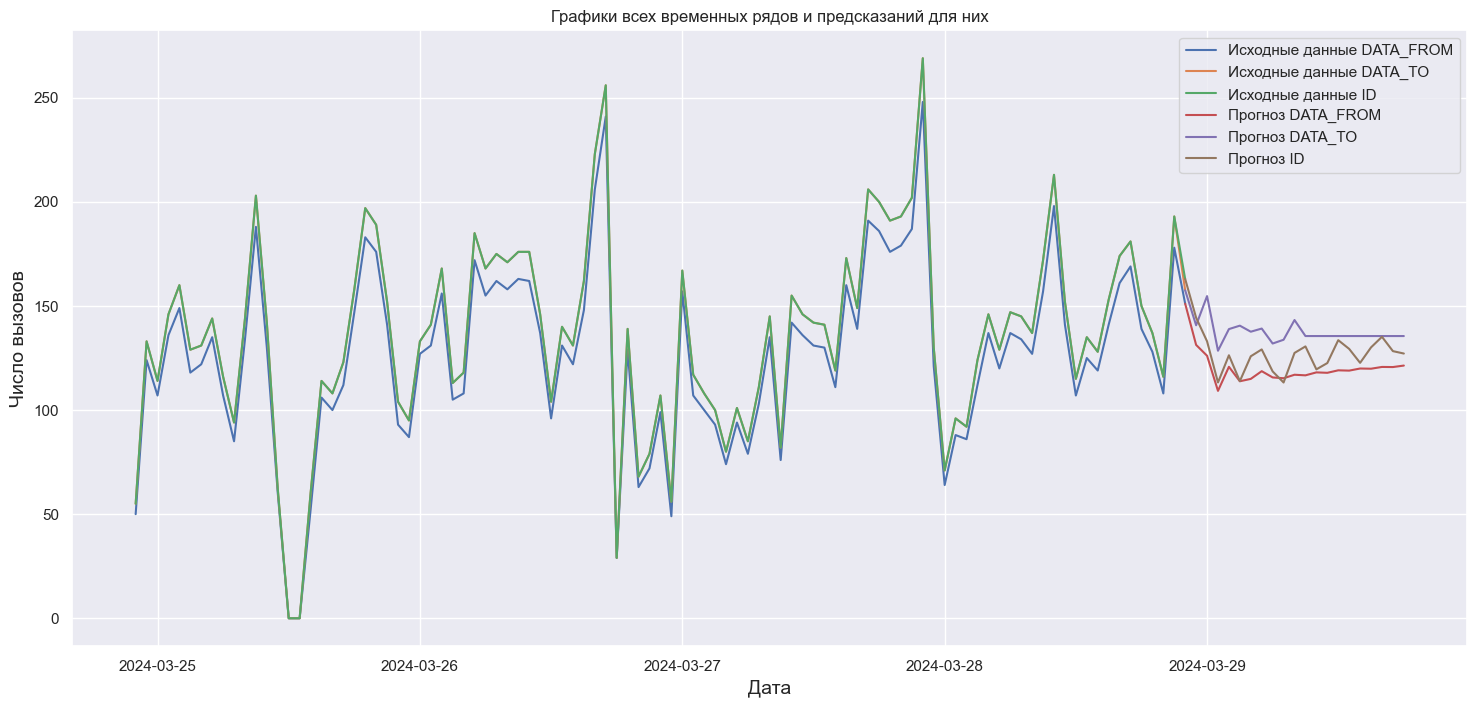

In [91]:
fig = plt.figure(figsize=(18, 8)) # задаем размер графиков
plt.title('Графики всех временных рядов и предсказаний для них') # подписываем график
plt.xlabel('Дата', fontsize=14) # подписываем ось х
plt.ylabel('Число вызовов', fontsize=14) # подписываем у 

plt.plot(train_from, label='Исходные данные DATA_FROM') # строим график train_from
plt.plot(train_to, label='Исходные данные DATA_TO') # строим график train_to
plt.plot(train_id, label='Исходные данные ID') # строим график train_id
plt.plot(predictions_from_mape, label='Прогноз DATA_FROM') # строим график prediction_from_mape
plt.plot(predictions_to_mae, label='Прогноз DATA_TO') # строим график prediction_to_mae
plt.plot(predictions_id_mae, label='Прогноз ID') # строим график prediction_id_mae

plt.legend() # добавляем легенду
plt.show() # выводим график на экран

По графику видно, что исходные данные DATA_TO и ID полностью совпадают, даннеы DATA_FROM немного отличаются

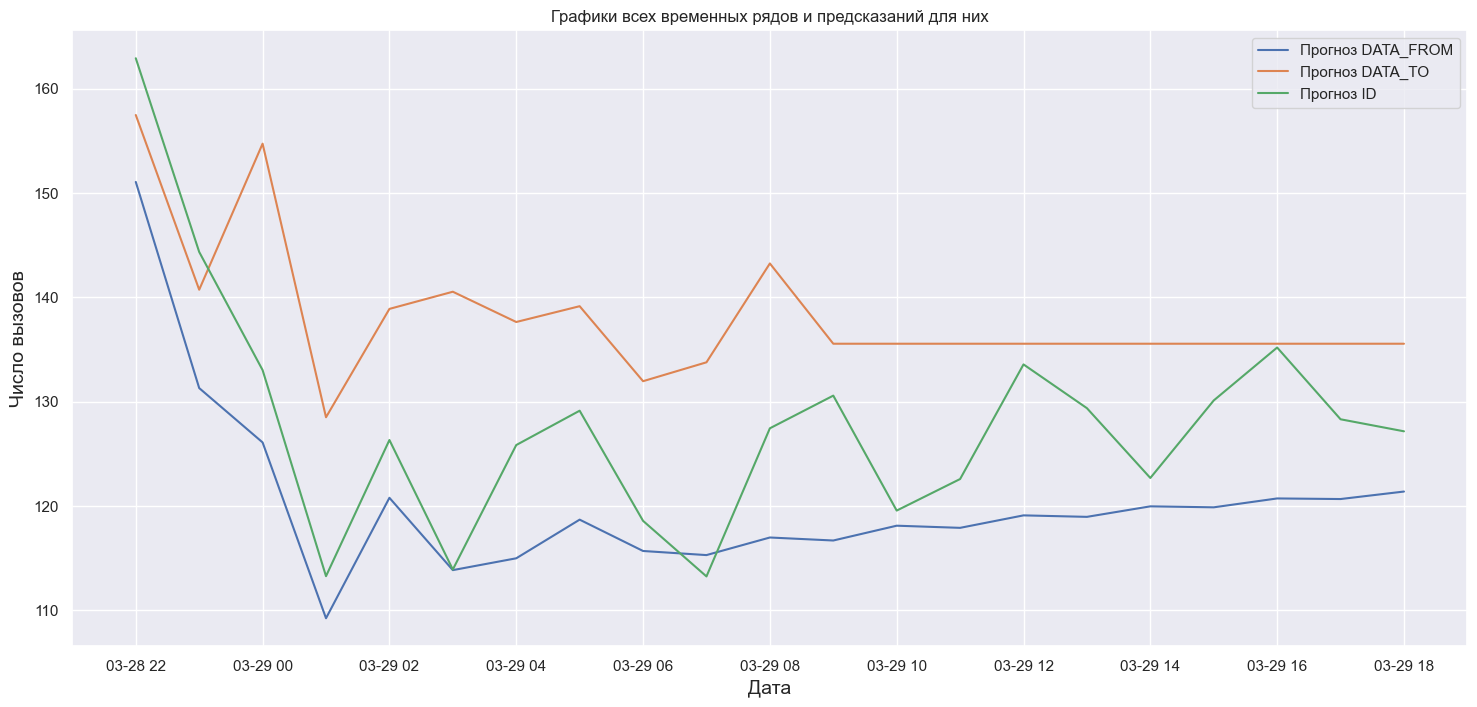

In [92]:
fig = plt.figure(figsize=(18, 8)) # задаем размер графиков
plt.title('Графики всех временных рядов и предсказаний для них')  # подписываем график
plt.xlabel('Дата', fontsize=14) # подписываем ось х
plt.ylabel('Число вызовов', fontsize=14) # подписываем у 

plt.plot(predictions_from_mape, label='Прогноз DATA_FROM') # строим график prediction_from_mape
plt.plot(predictions_to_mae, label='Прогноз DATA_TO') # строим график prediction_to_mae
plt.plot(predictions_id_mae, label='Прогноз ID') # строим график prediction_id_mae

plt.legend() # добавляем легенду
plt.show() # выводим график на экран